# A1: Python Analysis


Authors:
Leonardo Lecci
Xitlali Magana       
Nathalia Cardona
Riccardo Perez

## Introduction

The Ames Housing Dataset is a widely-used dataset for predicting the sale price of homes in Ames, Iowa. With 79 explanatory variables describing (almost) every aspect of residential homes, this dataset is a challenging task for predicting the final price of each home. Our team has analyzed this dataset and identified several crucial steps to prepare the data for predictive modeling. The most important step was cleaning the dataset and handling missing values. We also applied log transformations to skewed variables and dropped irrelevant columns. In addition, we created new features to capture additional information about the homes, such as the total square footage, the frequency of fireplaces, and the outdoor amenities area. Finally, we used one-hot encoding to convert categorical variables into numerical features. These steps were crucial in ensuring the accuracy and reliability of our predictive model. In this report, we will present our top three insights based on our analysis and modeling results.

In [123]:
# import libraries
import matplotlib.pyplot                as plt                                    # data visualization doc: https://matplotlib.org/2.0.2/api/pyplot_api.html
import pandas                           as pd                                     # data science essentials doc: https://pandas.pydata.org/docs/
import seaborn                          as sns                                    # enhanced data visualization doc: https://seaborn.pydata.org/
import numpy                            as np                                     # numpy library for math functions and arrays doc: https://numpy.org/doc/
from sklearn.model_selection            import train_test_split                   # train-test split doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html                                                                   
from sklearn.metrics                    import make_scorer, mean_squared_error    # metrics doc: https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.preprocessing              import StandardScaler                     # standard scaler doc: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from tpot                               import TPOTRegressor                      # doc: http://epistasislab.github.io/tpot/
import datetime                                                                   # datetime doc: https://docs.python.org/3/library/datetime.html

In [124]:
# read train dataset
train = pd.read_csv('train.csv')
train = train.set_index('Id')

# read test dataset
test = pd.read_csv('test.csv')
test = test.set_index('Id')

# create a column to identify if train or test
train['is_train'] = True
test['is_train'] = False

# merge the dataset test and train into all_data
all_data = pd.concat([train,test], axis=0)

## Cleaning Features


#### Output 1 - Count null values
Cleaning features and handling null values is an essential step in data analysis to ensure the accuracy and reliability of the results. Null values can arise from missing data, data corruption, or recording errors, and their presence can distort the analysis and lead to erroneous conclusions. Therefore, identifying and addressing null values appropriately is critical, such as imputing them with the median or mode value of the column. By cleaning both numerical and categorical features and handling null values, it can obtain a more accurate and reliable analysis, leading to better insights and informed decision-making.


In [125]:
# identify which features have missing values
all_data.isna().sum().to_frame().T

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,is_train
0,0,4,486,0,0,2721,0,0,2,0,...,2909,2348,2814,0,0,0,1,0,1459,0


In [126]:
########################### numeric features ############################## 
# creating a list of the numeric values 
numeric_features = all_data.select_dtypes(include=np.number).columns

# filling missing values for numeric values
for column in numeric_features:
    # identiyfing missing values
    if all_data[column].isna().sum() > 0:
        # identify the median of the column
        column_median = all_data[column].median()
        # fill the missing value with the column median 
        all_data[column] = all_data[column].fillna(column_median)


########################### categorical features  ############################## 
# separate the categorical features and the numeric features
categorical_features = set(all_data.columns) - set(numeric_features) - set(['is_train'])

# defining a function 
def fill_with_mode(df, columns):
    # filling missing categorial feature values
    for col in columns:
        # identifying the mode of the column
        mode = df[col].mode()[0]
        # fill missing value with the mode
        df[col] = df[col].fillna(mode)   
    return df

# clean categorical features using mode for train data
all_data = fill_with_mode(all_data, ['Electrical', 'Fence', 'MasVnrType', 'Functional'])

# STUFF I ADDED LATER
all_data = fill_with_mode(all_data, ['MSZoning', 'KitchenQual', 'Utilities', 'Exterior1st','Exterior2nd','SaleType'])

# clean other categorical features using "NA" where it's an option
# NA is not a null value, it is an actual input - checked the data description
all_data["FireplaceQu"].fillna(value = "NA", inplace = True)
all_data["GarageCond"].fillna(value = "NA", inplace = True)
all_data["GarageYrBlt"].fillna(value = "NA", inplace = True)
all_data["GarageType"].fillna(value = "NA", inplace = True)
all_data["GarageFinish"].fillna(value = "NA", inplace = True)
all_data["PoolQC"].fillna(value = "NA", inplace = True)
all_data["BsmtQual"].fillna(value = "NA", inplace = True)
all_data["GarageQual"].fillna(value = "NA", inplace = True)
all_data["Alley"].fillna(value = "NA", inplace = True)
all_data["BsmtFinType1"].fillna(value = "NA", inplace = True)
all_data["BsmtFinType2"].fillna(value = "NA", inplace = True)
all_data["BsmtCond"].fillna(value = "NA", inplace = True)
all_data["MiscFeature"].fillna(value = "NA", inplace = True)

########################### unique features  ##############################
# cleaning these columns separately
# basement exposure corresponds to the totalbsmtsf - use mode
all_data.loc[(all_data["BsmtExposure"].isna()) & (all_data["TotalBsmtSF"]==936), "BsmtExposure"] = all_data["BsmtExposure"].mode()[0]
# fill based on the previous output
all_data["BsmtExposure"].fillna(value = "NA", inplace = True)

# separate data based on bsmtfintype not being unfinished
all_data_filtered = all_data.loc[all_data["BsmtFinType2"] != 'Unf']
# bsmtfintype2 and bsmtfinsf2 and related - use mode
all_data.loc[(all_data["BsmtFinType2"].isna()) & (all_data["BsmtFinSF2"]!=0), "BsmtFinType2"] = all_data_filtered["BsmtFinType2"].mode()[0]
# fill with na based on previous output
all_data["BsmtFinType2"].fillna(value = "NA", inplace = True)

#### Output 2 - Ensure no null values

Ensuring that all missing values have been filled in a dataset is an important step in data preparation and analysis. Missing data can distort the results of statistical analyses, and omitting missing values can lead to biased and inaccurate conclusions. Additionally, some machine learning algorithms cannot handle missing data and may produce errors or inaccurate results if missing values are present.  By checking for missing values and ensuring that they have been filled, we can ensure the integrity and accuracy of our data analysis.

In [127]:
# ensure that all missing values have been filled
all_data.isna().sum().to_frame().T

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,is_train
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Engineering

In [128]:
# adding all of the square feet to determine total
# set a starting value for total square feet
all_data['tot_SF'] = 1
# for loop for all of the rows
for index, row in all_data.iterrows():
    # set val equal to garage finish to only add finished to tot_sf
    val = row['GarageFinish']
    # if garage is finished then add it to the total sq
    if val != 'Unf':
        all_data.loc[index,'tot_SF'] = all_data.loc[index,'GrLivArea'] + all_data.loc[index,'TotalBsmtSF'] - all_data.loc[index,'BsmtUnfSF'] + all_data.loc[index,'GarageArea']
    # if garage is unfinished then dont add it to the total sq
    else:
        all_data.loc[index,'tot_SF'] = all_data.loc[index,'GrLivArea'] + all_data.loc[index,'TotalBsmtSF'] - all_data.loc[index,'BsmtUnfSF']

# calculate the ratio of bethrooms per bedrooms
# for loop for all the rows
for index, row in all_data.iterrows():     
    # only use the rooms above ground
    if row['BedroomAbvGr'] > 0:
        all_data.loc[index,'BathPerBedroom'] = (all_data.loc[index,'FullBath'] +  all_data.loc[index,'HalfBath']) / all_data.loc[index,'BedroomAbvGr']
    else:
        all_data.loc[index,'BathPerBedroom'] = 0

# total porch area 
all_data['total_porch'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']

# has a feature 
# set starting value
all_data['has_garage'] = 0
all_data['has_masvnr'] = 0
all_data['has_pool']   = 0
all_data['has_porch']  = 0
# for loop for all the rows
for index, row in all_data.iterrows():
    # there is a garage area
    if all_data.loc[index,'GarageArea'] > 0:
        all_data.loc[index,'has_garage'] = 1
    # there is a masvnr area
    if all_data.loc[index,'MasVnrArea'] > 0:
        all_data.loc[index,'has_masvnr'] = 1 
    # there is a pool area
    if all_data.loc[index,'PoolArea'] > 0:
        all_data.loc[index,'has_pool'] = 1
    # there is a pool area
    if all_data.loc[index,'total_porch'] > 0:
        all_data.loc[index,'has_porch'] = 1

# total number of bathrooms            
all_data['TotBath'] = all_data['FullBath'] +  all_data['HalfBath'] +  all_data['BsmtFullBath'] + all_data['BsmtHalfBath']

# frequency of fireplaces compared to rooms above ground
all_data['FireplaceFreq'] =  all_data['Fireplaces'] / all_data['TotRmsAbvGrd']

# square footage of the outdoor amenitities
all_data['OutdoorAmenitiesArea'] = all_data['WoodDeckSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] + all_data['PoolArea'] 

# calculate the age of the house
all_data['house_age'] = datetime.datetime.now().year - all_data['YearBuilt']

# calculate how long since the last remodel
all_data['remodel_age'] = datetime.datetime.now().year - all_data['YearRemodAdd']

#### Visualization 1

Feature engineering is a crucial step in data analysis that involves creating new features from existing data to improve the accuracy of predictive models. By incorporating domain knowledge and statistical techniques, feature engineering can help identify key patterns and relationships in the data that would otherwise be difficult to detect. One way to assess the usefulness of these new features is to check their correlation with the target variable. This heatmap shows the linear correlation between a selection of newly engineered features and the sale price of houses in the dataset. By analyzing this heatmap, we can identify which features are most strongly correlated with sale price and may be valuable predictors in our analysis.

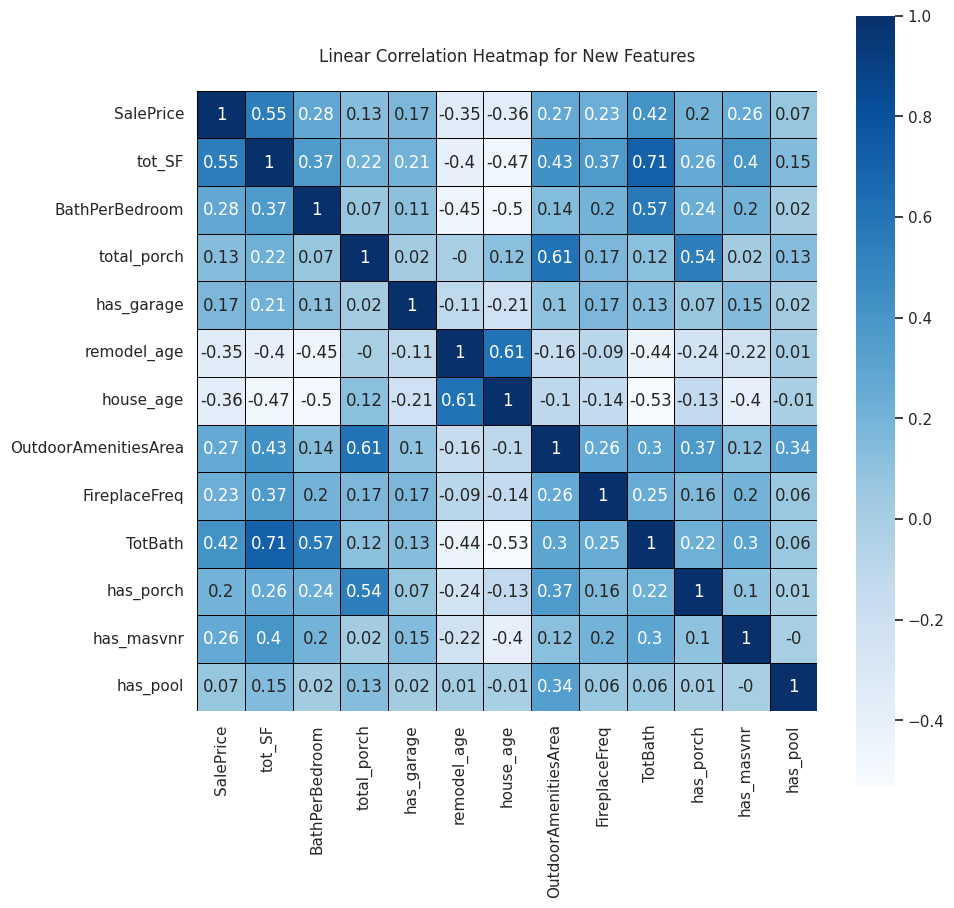

In [130]:
new_features = all_data[['SalePrice', 'tot_SF', 'BathPerBedroom', 'total_porch', 'has_garage',
                        'remodel_age', 'house_age', 'OutdoorAmenitiesArea', 'FireplaceFreq', 'TotBath',
                        'has_porch', 'has_masvnr', 'has_pool']]

corr_matrix = new_features.corr(method='pearson', min_periods=30).round(decimals=2)

# specifying plot size (making it bigger)
fig, ax = plt.subplots(figsize=(10, 10))

# developing a freezing cold heatmap
sns.heatmap(data=corr_matrix,  # the correlation matrix
            cmap='Blues',  # changing to COOL colors
            square=True,  # tightening the layout
            annot=True,  # should there be numbers in the heatmap
            linecolor='black',  # lines between boxes
            linewidths=0.5)  # how thick should the lines be?

# title and displaying the plot
plt.title(label="""
Linear Correlation Heatmap for New Features
""")

# rendering the visualization
plt.show()

## Skewness


#### Visualization 2
Skewness measures the degree of asymmetry in the distribution of a variable. Positively skewed data has a longer or fatter tail on the right side, while negatively skewed data has a longer or fatter tail on the left side. Skewness is important because many statistical methods and machine learning algorithms assume normal distributions, and skewed data can lead to biased or inaccurate results. One way to address skewness is by using a logarithmic transformation, which compresses the range of the variable and pulls in extreme values. This transformation can make the distribution of the data more symmetrical and closer to a normal distribution. By transforming the data, we can improve the accuracy and reliability of statistical methods and algorithms.

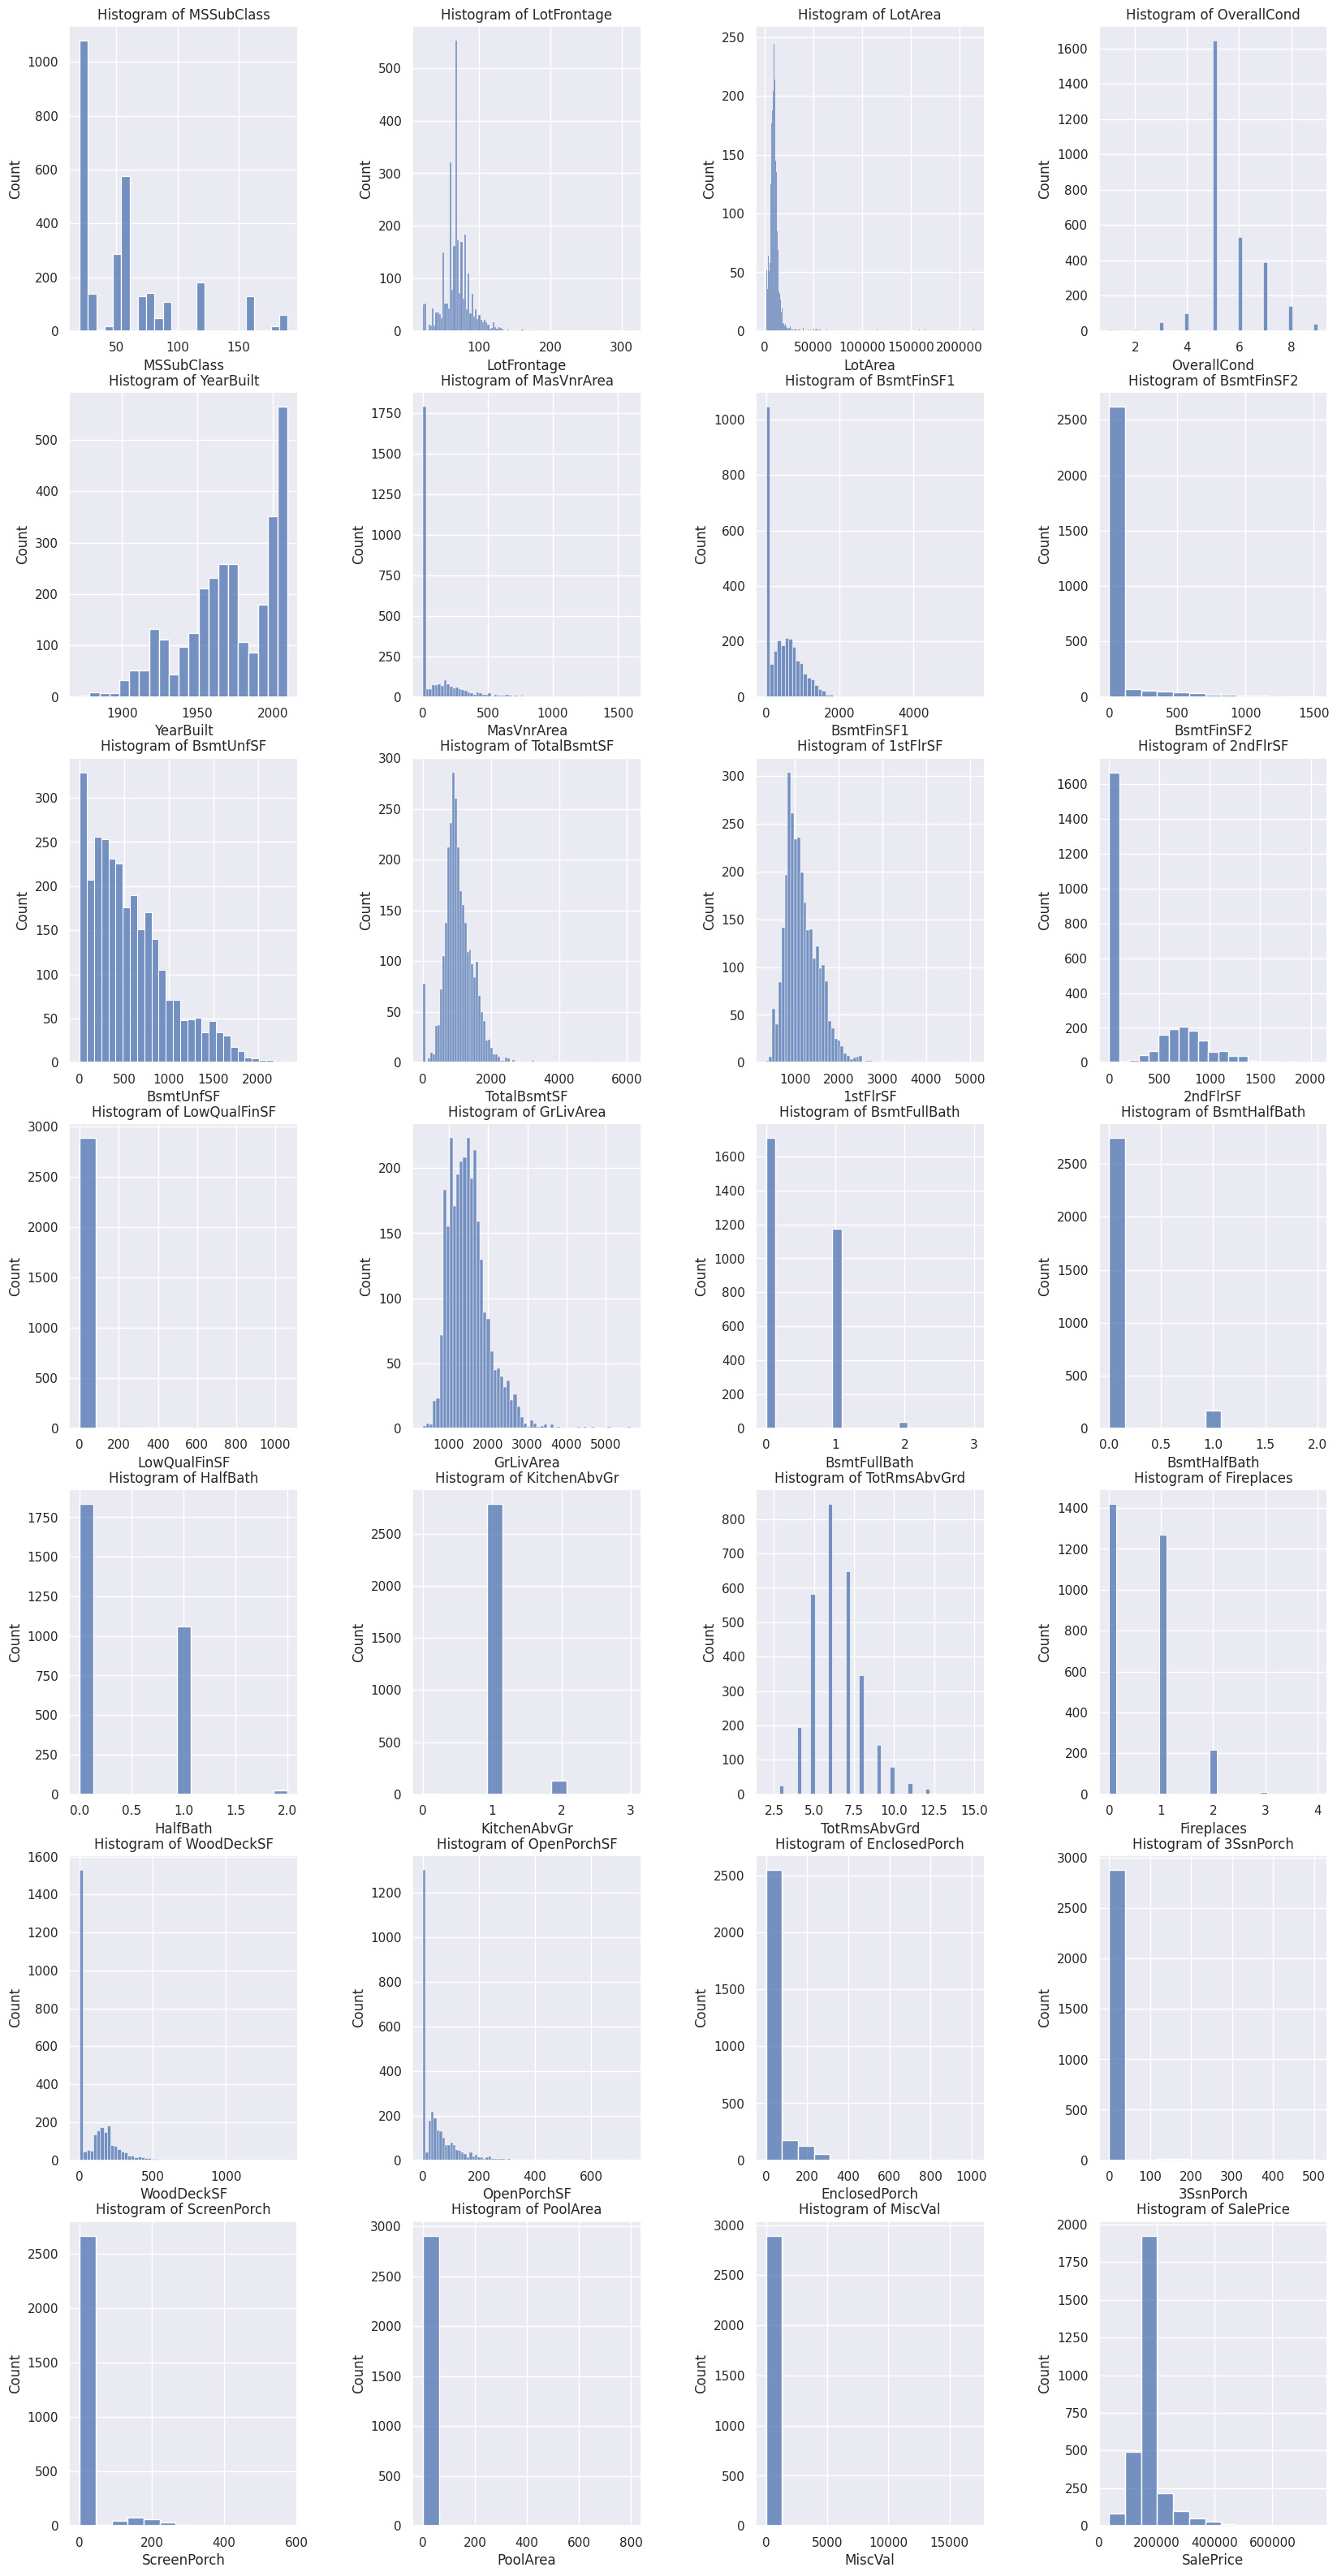

In [131]:
####################### SKEWNESS ############################
# set a threshold for skewness
skew_threshold = 0.5
# calculate the skewness of each column
skewness = all_data.skew()
# create a list of column names where the absolute value of skewness is greater than the threshold
skewed_columns = list(skewness[abs(skewness) > skew_threshold].index)

# create a grid of subplots
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 40))
# plot each histogram on a separate subplot
for ax, col in zip(axes.flat, skewed_columns):
    sns.histplot(data=all_data, x=col, kde=False, ax=ax)
    ax.set_title(f"Histogram of {col}")
# adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)
# display the plot
plt.show()

In [132]:
####################### LOG TRANSFORMATIONS ############################
# list of skewed columns
# removed the features that are years
skewed_columns = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 
                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                  'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                  'ScreenPorch', 'PoolArea', 'MiscVal', 
                  # add the engineered features 
                  'OutdoorAmenitiesArea', 'FireplaceFreq', 'tot_SF']
# for loop for the skewed columns
for col in skewed_columns:
    # log and create a new column 
    if col in all_data.columns:
        all_data['log_' + col] = np.log(all_data[col] + 0.001)

########################### DATA DROP ############################## 
# dropping skewed columns, but keep the logged ones
all_data = all_data.drop(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 
                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                  'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                  'ScreenPorch', 'PoolArea', 'MiscVal', 
                  'tot_SF', 'FireplaceFreq', 'OutdoorAmenitiesArea'],
                axis = 1)

## One-hot Encoding

#### Output 3 - cat_col
One-hot encoding is a technique used to transform categorical data into numerical data that can be used in machine learning models. Categorical features are those that contain a finite set of values, such as neighborhood or house style. Machine learning models require numerical data, and one-hot encoding is a common way to transform categorical features into numerical features. This technique creates new binary columns for each category in a categorical feature and assigns a 1 or 0 to each row depending on the category present in that row. 

In [133]:
# one hot encoding for categorical features
for cat_col in categorical_features:
    print(cat_col)
    # create df with one hot encoded variables
    one_hot_encoded_features = pd.get_dummies(all_data[cat_col])
    one_hot_encoded_features.columns = [cat_col + col for col in one_hot_encoded_features.columns]
    # combine one hot encode with the full dataset
    all_data = pd.concat([all_data, one_hot_encoded_features], axis = 1)
    # drop the columns no longer needed
    all_data = all_data.drop(cat_col, axis = 1)
    

Alley
LotConfig
ExterQual
SaleType
Condition1
GarageCond
BsmtCond
Street
Neighborhood
Exterior1st
LotShape
GarageFinish
BsmtQual
FireplaceQu
MSZoning
BsmtFinType2
Condition2
Exterior2nd
SaleCondition
HeatingQC
Heating
Foundation
BsmtExposure
RoofMatl
Functional
PavedDrive
MasVnrType
PoolQC
BsmtFinType1
RoofStyle
GarageType
MiscFeature
BldgType
LandContour
GarageQual
KitchenQual
CentralAir
Fence
ExterCond
Electrical
Utilities
LandSlope
HouseStyle


## Train/test split

In [134]:
# separate the full dataset into test and train
train = all_data[all_data.is_train==True]
test = all_data[all_data.is_train==False]

#### Output 4 - test_train_split

The train test split is an essential step in developing and evaluating machine learning models. The purpose of the split is to partition the data into two separate sets: a training set and a testing set.

The training set is used to train the model, while the testing set is used to evaluate its performance on data it has not seen before. By holding out a portion of the data for testing, we can assess how well the model generalizes to new, unseen data.

The split helps to prevent overfitting, which occurs when the model becomes too complex and fits too closely to the training data, resulting in poor performance on new data. By testing the model on a separate set of data, we can identify and correct for overfitting, leading to a more robust and accurate model.

In [135]:
# drop the test/train column
train = train.drop('is_train', axis = 1)
train.head( n = 5 )

,OverallQual,YearBuilt,YearRemodAdd,FullBath,BedroomAbvGr,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold,...,LandSlopeMod,LandSlopeSev,HouseStyle1.5Fin,HouseStyle1.5Unf,HouseStyle1Story,HouseStyle2.5Fin,HouseStyle2.5Unf,HouseStyle2Story,HouseStyleSFoyer,HouseStyleSLvl
Id,,,,,,,,,,,,,,,,,,,,,
1,7,2003,2003,2,3,2003.0,2.0,548.0,2,2008,...,0,0,0,0,0,0,0,1,0,0
2,6,1976,1976,2,3,1976.0,2.0,460.0,5,2007,...,0,0,0,0,1,0,0,0,0,0
3,7,2001,2002,2,3,2001.0,2.0,608.0,9,2008,...,0,0,0,0,0,0,0,1,0,0
4,7,1915,1970,1,3,1998.0,3.0,642.0,2,2006,...,0,0,0,0,0,0,0,1,0,0
5,8,2000,2000,2,4,2000.0,3.0,836.0,12,2008,...,0,0,0,0,0,0,0,1,0,0


In [136]:
# drop the test/train column
test = test.drop('is_train', axis = 1)
test.head( n = 5 )

,OverallQual,YearBuilt,YearRemodAdd,FullBath,BedroomAbvGr,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold,...,LandSlopeMod,LandSlopeSev,HouseStyle1.5Fin,HouseStyle1.5Unf,HouseStyle1Story,HouseStyle2.5Fin,HouseStyle2.5Unf,HouseStyle2Story,HouseStyleSFoyer,HouseStyleSLvl
Id,,,,,,,,,,,,,,,,,,,,,
1461,5,1961,1961,1,2,1961.0,1.0,730.0,6,2010,...,0,0,0,0,1,0,0,0,0,0
1462,6,1958,1958,1,3,1958.0,1.0,312.0,6,2010,...,0,0,0,0,1,0,0,0,0,0
1463,5,1997,1998,2,3,1997.0,2.0,482.0,3,2010,...,0,0,0,0,0,0,0,1,0,0
1464,6,1998,1998,2,3,1998.0,2.0,470.0,6,2010,...,0,0,0,0,0,0,0,1,0,0
1465,8,1992,1992,2,2,1992.0,2.0,506.0,1,2010,...,0,0,0,0,1,0,0,0,0,0


In [137]:
# identifying x variables
x_labels = [x for x in list(train.columns) if x != 'SalePrice' and x!= 'Id']

# identify y variable
y_labels = ['SalePrice']

# split the dataset into train and test using the seed 219 to make sure the results are replicable
x_train, x_test, y_train, y_test = train_test_split(
            train[x_labels], # x-variables (can change this)
            train[y_labels], # y-variable  (can change this)
            test_size    = 0.25,
            random_state = 219)

## Models, Hyperparameter Tuning, Model Tournament and Selection

### TPOT (Tree-Based Pipeline Optimization Tool)
In creating a machine learning model to predict housing prices in Kaggle's test dataset, a new and more efficient approach was taken rather than the traditional method of model selection and tuning for the Ames Housing dataset (KRAWIEC, 2002).

After cleaning and engineering the data, a typical process involves tuning the hyperparameters of selected machine learning models (TPOT, n.d.). However, this process can be time-consuming when using methods like GridSearch or RandomSearch, or even more advanced ones like Coarse to Fine. Instead, a Python Automated Machine Learning tool called TPOT was used.

TPOT uses genetic programming to optimize machine learning pipelines automatically. This approach can save a significant amount of time and effort compared to manual tuning methods and can lead to more accurate predictions for the Ames Housing dataset (Olson & Moore, 2016).

Our function, 'tpot_rmse()', helps us find the best way to predict house prices using a dataset called Ames Housing. It uses a program called TPOT to try out lots of different ways to analyze the data automatically. By default, TPOT would try 10,000 ways and return the best one, but it was made to try 750 ways to save time.



In [88]:
def tpot_rmse(x_train, y_train, x_test, y_test, generations= 100,  population_size = 100):
    # Define custom scoring function as RMSE
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # Define TPOTRegressor with custom scoring function
    tpot = TPOTRegressor(generations     = generations, 
                         population_size = population_size,
                         scoring         = "neg_root_mean_squared_error",
                         verbosity       = 2,
                         random_state    = 42,
                         n_jobs          = -1)

    # Fit the TPOT Regressor to the training data
    tpot.fit(x_train, y_train)
    
    # Calculate predictions on test set
    y_pred = tpot.predict(x_test)
    
    # Calculate RMSE on test set
    rmse = mean_squared_error(y_test, y_pred)
    
    return tpot, rmse

tpot, rmse = tpot_rmse(x_train, np.log(np.ravel(y_train)), x_test, np.log(np.ravel(y_test)), generations=10, population_size=75)

                                                                                
Generation 1 - Current best internal CV score: -0.13476677137377827
                                                                              
Generation 2 - Current best internal CV score: -0.13358749578125115
                                                                                
Generation 3 - Current best internal CV score: -0.1260906900513729
                                                                                
Generation 4 - Current best internal CV score: -0.1260906900513729
                                                                                
Generation 5 - Current best internal CV score: -0.1260906900513729
                                                                                  
                                                                                
TPOT closed during evaluation in one generation.
                                               

In [138]:
print ("""
Model \t\t\t\t Parameters 
------------------------------------------------------------------------------------------------------------------
RandomForestRegressor            LassoLarsCV(input_matrix, normalize=False), bootstrap=False, max_features=0.35, 
                                 in_samples_leaf=2, min_samples_split=9, n_estimators=100 
""")



Model 				 Parameters 
------------------------------------------------------------------------------------------------------------------
RandomForestRegressor            LassoLarsCV(input_matrix, normalize=False), bootstrap=False, max_features=0.35, 
                                 in_samples_leaf=2, min_samples_split=9, n_estimators=100 



#### Output 5 - Selected Pipeline
The model has different settings called hyperparameters that need to be chosen before it can make predictions. Here's what they mean:

- The first step is to select the most important features from the input data using a method called LassoLars. 
- The data is not changed to make it easier to work with.
- The model is made up of 100 decision trees that work together to make predictions.
- Each tree only considers a maximum of 35% of the available features at each split.
- A node in the tree will only be split if it has at least 9 samples in it.
- Each leaf of the tree must contain at least 2 samples.
- The model doesn't use bootstrapping, which means it uses the entire dataset instead of a sample when building each decision tree.

#### Output 6 - Root Mean Squared Error
Root Mean Squared Error (RMSE) is a metric used in machine learning to measure how accurately a model can predict outcomes. In the context of predicting house prices, RMSE is used to measure how far off the predicted prices are from the actual prices.
By minimizing the RMSE, we can improve the accuracy of the model and make more precise predictions. This is important when predicting house prices, as even small errors can have a big impact on the overall value of a property. A model with a lower RMSE is therefore more reliable and useful for making important decisions, such as determining the value of a property or making investment decisions in the real estate market.

In [ ]:
np.sqrt(rmse)

0.10894657481923675

#### Visualization 3 - Model improving in predicting Sale Prices
Internal cross-validation is a process used to test how well a machine learning model can make accurate predictions. It works by splitting the data into multiple parts, and then training and testing the model on different combinations of those parts. The purpose is to assess the model's performance on data it hasn't seen before, which helps to ensure that it can generalize well to new data.

In the case of the TPOT model for predicting house prices based on the Ames Housing Dataset, it's good that the internal cross-validation scores are improving over time. This means that as the model is refined through multiple generations, it is getting better at accurately predicting house prices. As a result, it is more likely to make accurate predictions on new, unseen data. This is important because it ensures that the model will be useful for predicting house prices in the real world, and not just on the data it was trained on.

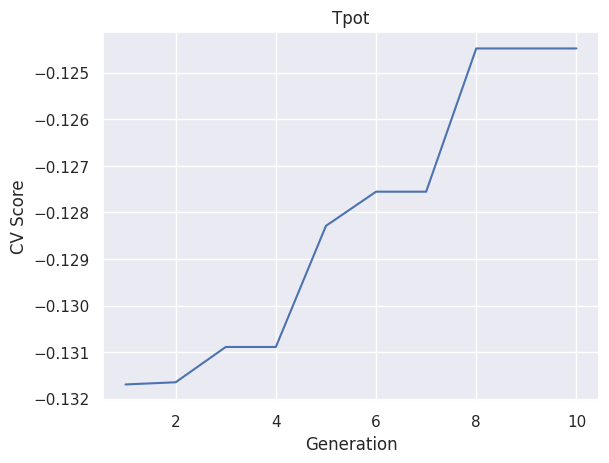

In [139]:
# Define the data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [-0.13169253606273906, -0.1316457681655923, -0.13088761399045154, -0.13088761399045154, 
     -0.12828717873322373, -0.12755314102621765, -0.12755314102621765, -0.12447715417761518,
     -0.12447715417761518, -0.12447715417761518]

# Set the style
sns.set_style('darkgrid')

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('Generation')
plt.ylabel('CV Score')
plt.title('Tpot')

# Show the plot
plt.show()

## Saving Y_test for submission

In [ ]:
# y_prediction = tpot.predict(test[x_labels])
# np.exp(y_prediction)

# submission = pd.DataFrame()
# submission['Id'] = test.index
# submission['SalePrice'] = np.exp(y_prediction)

# submission = submission.set_index('Id')

# submission.to_csv('submission_team10_tpot.csv')

/Users/ricky/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoLarsCV was fitted with feature names
  warnings.warn(


array([124363.34336931, 155310.38120913, 173669.55922707, ...,
       163387.19844411, 117494.06213411, 233335.84151178])

## Top Three Actionable Insights

After conducting a thorough analysis of the dataset, we have identified several actionable insights that can help improve the overall value of a property. 

1) Our analysis shows that the number of bathrooms in a property is more critical than the number of bedrooms when it comes to determining its value, with a correlation coefficient of 0.42 between the number of total bathrooms and sale price. This indicates that having an adequate number of bathrooms can greatly improve a home's functionality and livability and increase its value. This is likely due to the fact that people value privacy and convenience when it comes to bathrooms, and having an adequate number of bathrooms can greatly improve a home's functionality and livability. Additionally, the correlation coefficient of 0.28 between bath per bedroom and sale price suggests that the ratio of bathrooms to bedrooms is not as essential to consider when evaluating a property. In contrast, the number of bedrooms may not be as critical, as some people may prefer larger bedrooms or use them for other purposes such as a home office or gym.

2) Another key insight that our analysis has revealed is that having a pool does not appear to be a significant factor in determining the value of a property, with a correlation coefficient of only 0.07 between having a pool and sale price. Instead, adding a garage or porch appears to be more critical, with a correlation coefficient of 0.2 for having a porch and 0.17 for having a garage. This indicates that the additional space and functionality provided by a garage or porch can have a more significant impact on the value of a property than a pool, which may require additional maintenance and upkeep, as well as the limited usability in some climates. In contrast, a garage provides a convenient and secure location to store vehicles, while a porch provides additional space for outdoor living and entertaining. 

3) Finally, our analysis suggests that having a porch can greatly impact the value of a property, regardless of its size, with a correlation coefficient of 0.2 between having a porch and sale price, and a correlation coefficient of 0.13 between total porch area and sale price. This suggests that even a small porch can provide significant value to a home. This is because a porch provides a space where people can relax and enjoy the outdoors without having to leave the comfort of their home. In contrast, the size of the porch does not have as much of an impact on the value of the property.


## Conclusion
In conclusion, this analysis has provided valuable insights into the factors that can impact the value of a property. By focusing on features such as bathrooms, garages, and porches, rather than just the number of bedrooms or square footage, homeowners and real estate agents can make informed decisions to increase the value of a property. The analysis indicates that having an adequate number of bathrooms is more critical than the number of bedrooms, while having a pool is not as important as having a garage or porch. The size of the porch was found to be less critical than the presence of a porch, as even a small porch can add significant value to a home. These findings highlight the importance of considering a range of factors when evaluating a property, in order to provide a better understanding of what potential buyers are looking for and make informed decisions to increase the overall value of a property.

## Bibliography

- Lisi. (2019). Sales comparison approach, multiple regression analysis and the implicit prices of housing. Journal of Property Research, 36(3), 272–290. https://doi.org/10.1080/09599916.2019.1651755
- Montero José-María, Mínguez Román, & Fernández-Avilés Gema. (2018). Housing price prediction: parametric versus semi-parametric spatial hedonic models. Journal of Geographical Systems : Geographical Information, Analysis, Theory, and Decision, 20(1), 27–55. https://doi.org/10.1007/s10109-017-0257-y
- Soltani, A., Heydari, M., Aghaei, F., & Pettit, C. J. (2022). Housing price prediction incorporating spatio-temporal dependency into machine learning algorithms. Cities, 131. https://doi.org/10.1016/j.cities.2022.103941
- TPOT. (n.d.). Epistasislab.github.io. http://epistasislab.github.io/tpot/
- KRAWIEC, K. (2002). Genetic Programming-based Construction of Features for Machine Learning and Knowledge Discovery Tasks. Research Gate. https://www.researchgate.net/profile/Krzysztof-Krawiec/publication/216300978_Genetic_Programming-based_Construction_of_Features_for_Machine_Learning_and_Knowledge_Discovery_Tasks/links/0046351e24f3eb3cb0000000/Genetic-Programming-based-Construction-of-Features-for-Machine-Learning-and-Knowledge-Discovery-Tasks.pdf
- Olson, R. S., & Moore, J. H. (2016, December 4). TPOT: A Tree-based Pipeline Optimization Tool for Automating Machine Learning. Proceedings.mlr.press; PMLR. https://proceedings.mlr.press/v64/olson_tpot_2016


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=873dd50c-8355-4edd-aff2-41c0b115c821' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>